In [1]:
import pandas as pd
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

train_csv = pd.read_csv('GermanSigns/Train.csv')
dataset_x = []
dataset_y = []

for index, f in tqdm(train_csv.iterrows()):
    if f['Width'] < 32 or f['Height'] < 32:
        continue
    
    img = cv2.imread('GermanSigns/' + f['Path'])
    img = img[f['Roi.X1']:f['Roi.X2'], f['Roi.Y1']:f['Roi.Y2']]
    if f['Width'] < 32 or f['Height'] < 32:
        img = cv2.resize(img, (64, 64), interpolation=cv2.INTER_CUBIC)
    else:
        img = cv2.resize(img, (64, 64), interpolation=cv2.INTER_AREA)
        
    dataset_x.append(img)
    dataset_y.append([f['ClassId']])

dataset_x = np.array(dataset_x) / 255
dataset_y = np.array(dataset_y)

39209it [00:46, 844.40it/s] 


In [2]:
test_csv = pd.read_csv('GermanSigns/Test.csv')
test_x = []
test_y = []

for index, f in tqdm(test_csv.iterrows()):
    if f['Width'] < 32 or f['Height'] < 32:
        continue
    
    img = cv2.imread('GermanSigns/' + f['Path'])
    img = img[f['Roi.X1']:f['Roi.X2'], f['Roi.Y1']:f['Roi.Y2']]
    if f['Width'] < 32 or f['Height'] < 32:
        img = cv2.resize(img, (64, 64), interpolation=cv2.INTER_CUBIC)
    else:
        img = cv2.resize(img, (64, 64), interpolation=cv2.INTER_AREA)
        
    test_x.append(img)
    test_y.append([f['ClassId']])

test_x = np.array(test_x) / 255
test_y = np.array(test_y)

12630it [00:24, 506.19it/s]


In [4]:
np.save('GermanSigns/dataset_x.npy', dataset_x)
np.save('GermanSigns/dataset_y.npy', dataset_y)
np.save('GermanSigns/test_x.npy', test_x)
np.save('GermanSigns/test_y.npy', test_y)

Train Input Shape: (32704, 64, 64, 3)
Train Ouput Shape: (32704, 1)
Test Input Shape: (10338, 64, 64, 3)
Test Ouput Shape: (10338, 1)
# of Classes: 43


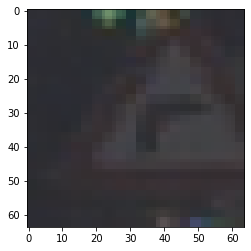

In [3]:
print('Train Input Shape:', dataset_x.shape)
print('Train Ouput Shape:', dataset_y.shape)
print('Test Input Shape:', test_x.shape)
print('Test Ouput Shape:', test_y.shape)
print('# of Classes:', len(np.unique(dataset_y)))
plt.imshow(cv2.cvtColor((dataset_x[0] * 255).astype(np.uint8), cv2.COLOR_BGR2RGB))

In [4]:
from sklearn.model_selection import train_test_split

train_x, valid_x, train_y, valid_y = train_test_split(dataset_x, dataset_y, test_size=0.3, random_state=101)

In [18]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, ReLU

cnn_model = Sequential()

cnn_model.add(Conv2D(64, 3, 3, input_shape=(64, 64, 3), padding='same'))
cnn_model.add(ReLU())
cnn_model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
cnn_model.add(Dropout(0.2))

cnn_model.add(Conv2D(128, 3, 3, input_shape=(32, 32, 64), padding='same'))
cnn_model.add(ReLU())
cnn_model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
cnn_model.add(Dropout(0.2))

cnn_model.add(Conv2D(64, 3, 3, input_shape=(16, 16, 128), padding='same'))
cnn_model.add(ReLU())
cnn_model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
cnn_model.add(Dropout(0.2))

cnn_model.add(Flatten())
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dense(43, activation='softmax'))

cnn_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [22]:
cnn_model.fit(train_x, train_y, batch_size=512, epochs=5, verbose=1, validation_data=(valid_x, valid_y))

Epoch 1/5
45/45 [==============================] - 30s 651ms/step - loss: 0.7033 - accuracy: 0.7719 - val_loss: 0.4473 - val_accuracy: 0.8718
Epoch 2/5
45/45 [==============================] - 21s 462ms/step - loss: 0.6714 - accuracy: 0.7816 - val_loss: 0.4323 - val_accuracy: 0.8781
Epoch 3/5
45/45 [==============================] - 19s 436ms/step - loss: 0.6345 - accuracy: 0.7931 - val_loss: 0.4104 - val_accuracy: 0.8854
Epoch 4/5
45/45 [==============================] - 15s 343ms/step - loss: 0.6106 - accuracy: 0.8014 - val_loss: 0.3787 - val_accuracy: 0.8920
Epoch 5/5
45/45 [==============================] - 20s 450ms/step - loss: 0.5851 - accuracy: 0.8083 - val_loss: 0.3628 - val_accuracy: 0.8984


In [23]:
from sklearn.metrics import classification_report

prediction = np.argmax(cnn_model.predict(test_x), axis=1)

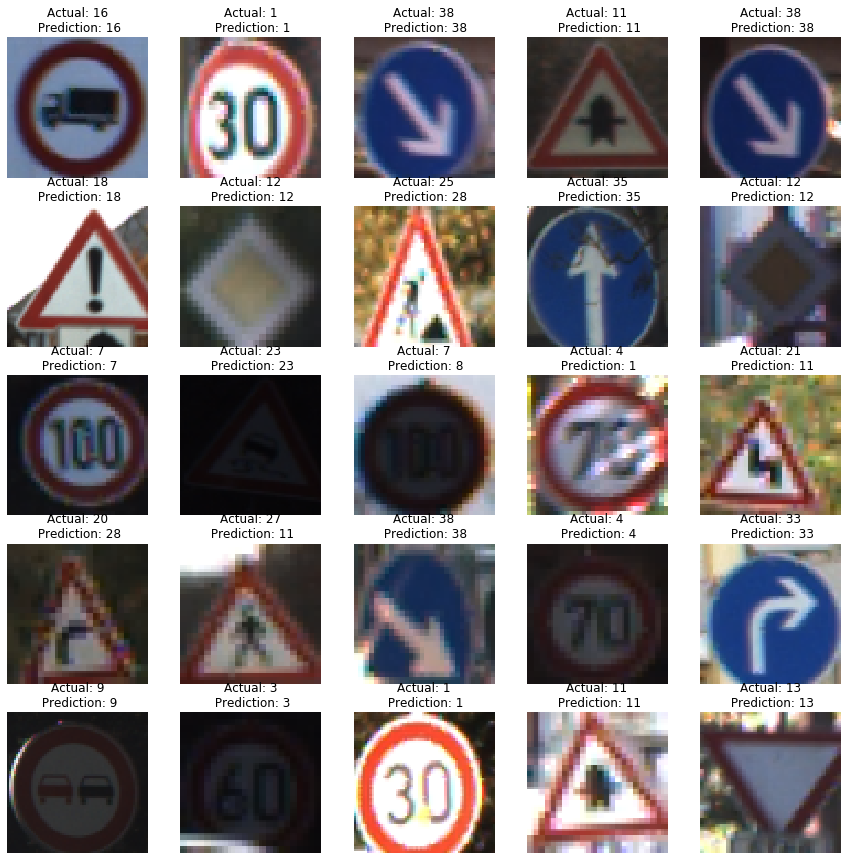

In [24]:
length = 5
width = 5
fig, axes = plt.subplots(length, width, figsize=(15, 15))
axes = axes.ravel()

for i in range(length*width):
    axes[i].imshow(cv2.cvtColor((test_x[i]*255).astype(np.uint8), cv2.COLOR_BGR2RGB))
    axes[i].set_title('Actual: %s\n Prediction: %s' % (test_y[i, 0], prediction[i]))
    axes[i].axis('off')

In [25]:
print(classification_report(test_y, prediction, target_names=['Class: ' + str(i) for i in range(43)]))

              precision    recall  f1-score   support

    Class: 0       0.67      0.04      0.08        50
    Class: 1       0.76      0.89      0.82       629
    Class: 2       0.78      0.73      0.76       615
    Class: 3       0.79      0.86      0.83       322
    Class: 4       0.94      0.87      0.90       526
    Class: 5       0.70      0.75      0.72       461
    Class: 6       0.86      0.74      0.80        93
    Class: 7       0.79      0.67      0.73       362
    Class: 8       0.64      0.66      0.65       355
    Class: 9       0.98      0.95      0.96       401
   Class: 10       0.95      0.94      0.95       480
   Class: 11       0.82      0.89      0.85       388
   Class: 12       0.99      0.95      0.97       593
   Class: 13       0.98      0.96      0.97       661
   Class: 14       0.96      0.94      0.95       249
   Class: 15       0.88      0.97      0.92       171
   Class: 16       0.98      0.97      0.98       126
   Class: 17       0.95    

In [26]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0
